 # Diamond Price Regression Notebook

 Using Polynomial Regression and Exploratory Data Analysis

# 1️⃣ Setup & Imports 

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style("whitegrid")


 # 2️⃣ Data Loading & Initial Cleaning

In [8]:
df = pd.read_csv("diamonds.csv")
df = df.drop(columns=["Unnamed: 0"], axis=1)
df = df.drop_duplicates()

# Create derived features
df["volume"] = df["x"] * df["y"] * df["z"]
df["aspect_ratio"] = df["x"] / df["y"]
df["carat_per_volume"] = df["carat"] / df["volume"]
df["depth_table_ratio"] = df["depth"] / df["table"]


 # 3️⃣ Encode Categorical Features

In [9]:
category_orders = {
    "clarity": {
        "I1": 1,
        "SI2": 2,
        "SI1": 3,
        "VS2": 4,
        "VS1": 5,
        "VVS2": 6,
        "VVS1": 7,
        "IF": 8,
    },
    "cut": {"Fair": 1, "Good": 2, "Very Good": 3, "Premium": 4, "Ideal": 5},
    "color": {"J": 1, "I": 2, "H": 3, "G": 4, "F": 5, "E": 6, "D": 7},
}

for col, mapping in category_orders.items():
    df[col + "_encoded"] = df[col].map(mapping)

categorical_columns = ["cut", "color", "clarity"]
numerical_columns = [
    "carat",
    "depth",
    "table",
    "x",
    "y",
    "z",
    "volume",
    "aspect_ratio",
    "carat_per_volume",
    "depth_table_ratio",
    "cut_encoded",
    "color_encoded",
    "clarity_encoded",
]
target_column = "price"


 # 4️⃣ Clean & Filter Data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53794 entries, 0 to 53939
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   carat              53794 non-null  float64
 1   cut                53794 non-null  object 
 2   color              53794 non-null  object 
 3   clarity            53794 non-null  object 
 4   depth              53794 non-null  float64
 5   table              53794 non-null  float64
 6   price              53794 non-null  int64  
 7   x                  53794 non-null  float64
 8   y                  53794 non-null  float64
 9   z                  53794 non-null  float64
 10  volume             53794 non-null  float64
 11  aspect_ratio       53788 non-null  float64
 12  carat_per_volume   53794 non-null  float64
 13  depth_table_ratio  53794 non-null  float64
 14  clarity_encoded    53794 non-null  int64  
 15  cut_encoded        53794 non-null  int64  
 16  color_encoded      53794 no

In [11]:
df.describe()

/home/kraigochieng/miniconda3/envs/data_science/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,carat,depth,table,price,x,y,z,volume,aspect_ratio,carat_per_volume,depth_table_ratio,clarity_encoded,cut_encoded,color_encoded
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53788.000000,5.379400e+04,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714,129.826975,0.999398,inf,1.076526,4.051920,3.904134,4.406086
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037,78.160819,0.012444,NaN,0.053358,1.646857,1.116098,1.701117
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.207522e-04,0.616842,1.000000,1.000000,1.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000,65.190168,0.992614,6.048225e-03,1.045763,3.000000,3.000000,3.000000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,114.840180,0.995736,6.117026e-03,1.082456,4.000000,4.000000,4.000000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000,170.823600,1.006944,6.190082e-03,1.112500,5.000000,5.000000,6.000000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,3840.598060,1.615572,inf,1.462791,8.000000,5.000000,7.000000


In [12]:
# Replace inf / -inf and drop NaNs
df[numerical_columns + [target_column]] = df[
    numerical_columns + [target_column]
].replace([np.inf, -np.inf], np.nan)

df = df.dropna()

# Filter based on reasonable ranges

df = df[
    (df["x"] > 0)
    & (df["y"] > 0)
    & (df["z"] > 0)
    & (df["carat"] > 0)
    & (df["carat_per_volume"] > 0.006)
    & (df["price"] > 0)
]
df = df[
    df["depth"].between(50, 75)
    & df["table"].between(50, 75)
    & df["aspect_ratio"].between(0.96, 1.04)
    & df["depth_table_ratio"].between(0.8, 1.3)
]
df = df[df["volume"] < df["volume"].quantile(0.99)]
df = df[df["carat_per_volume"] < df["carat_per_volume"].quantile(0.99)]

print("Original size:", df.shape)
print("Cleaned size:", df.shape)


Original size: (46235, 17)
Cleaned size: (46235, 17)


 # 5️⃣ Exploratory Data Analysis (EDA)

 ## 5a. Numerical Features

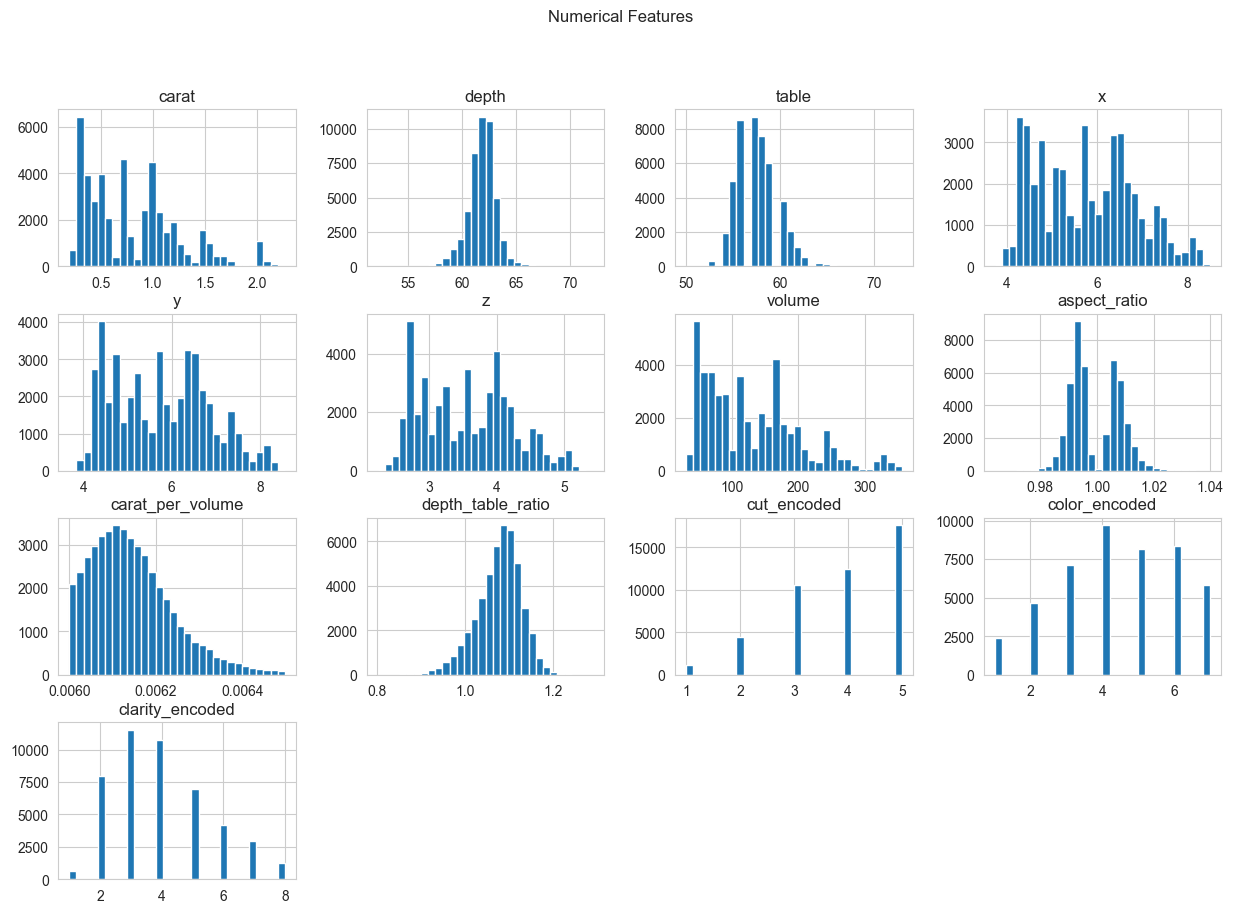

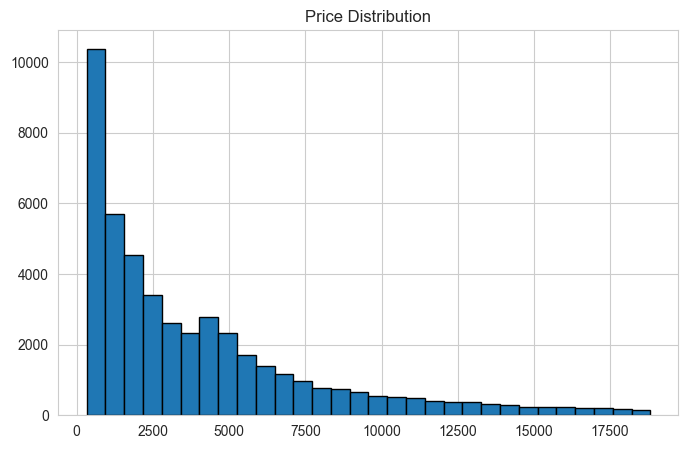

In [13]:
# Histograms
df[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.suptitle("Numerical Features")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(df[target_column], bins=30, edgecolor="black")
plt.title("Price Distribution")
plt.show()


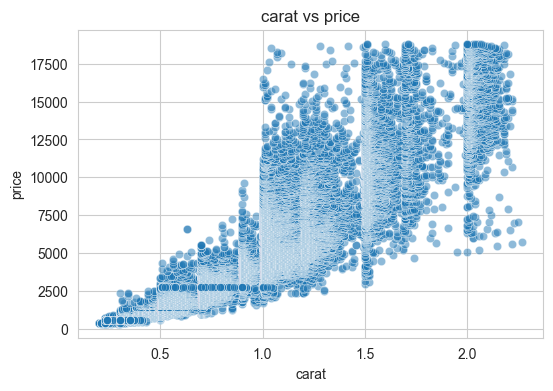

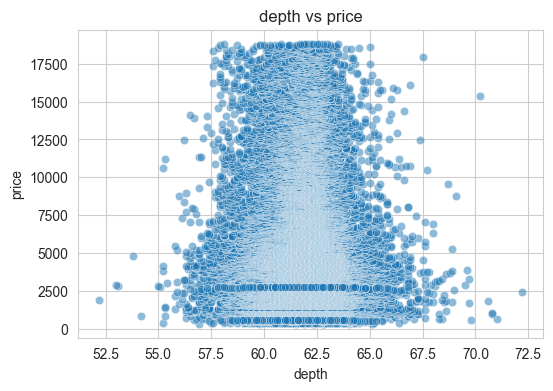

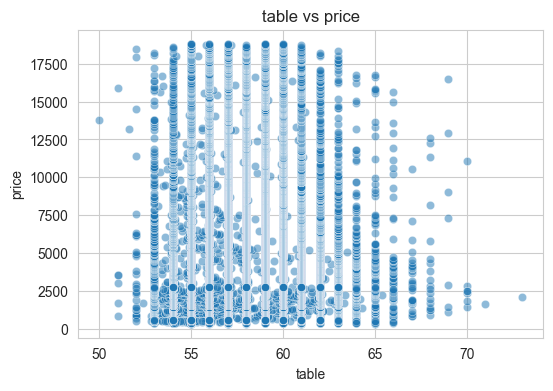

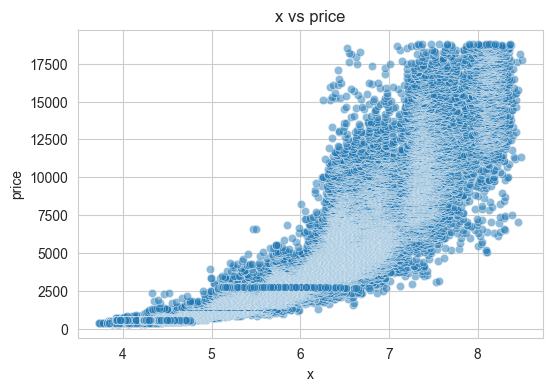

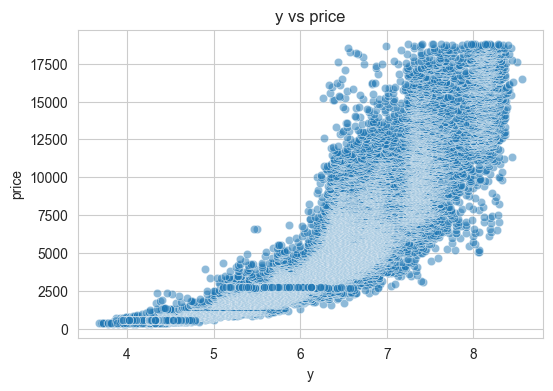

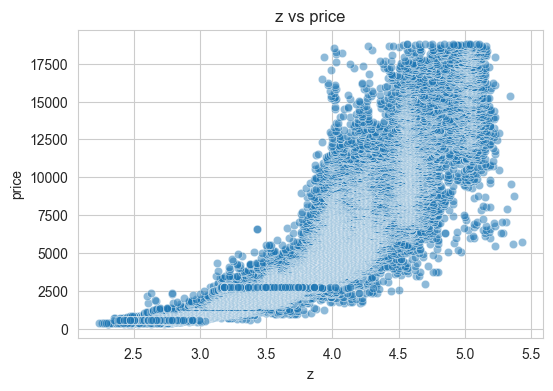

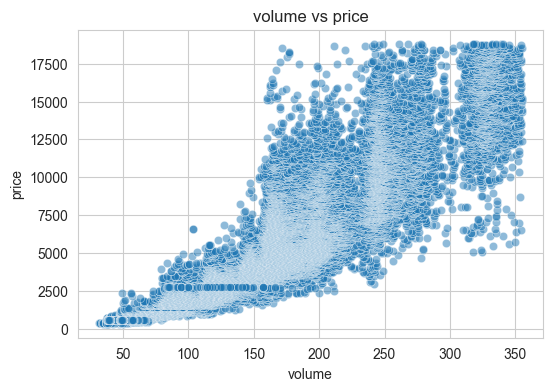

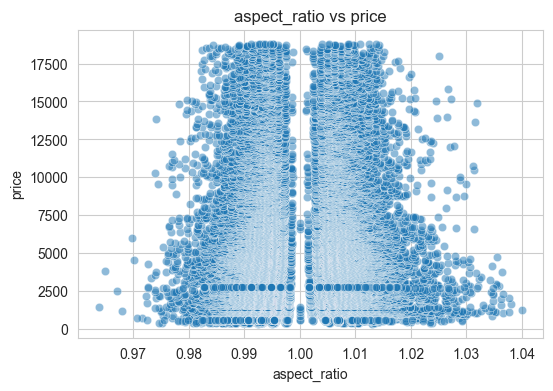

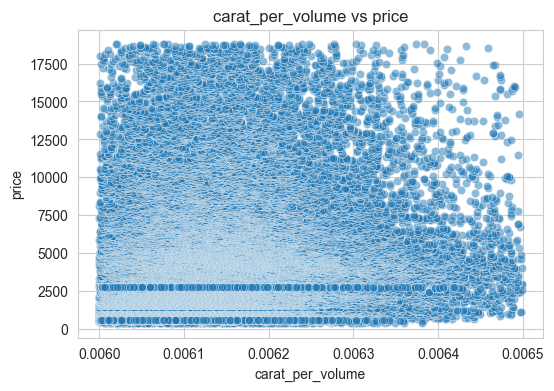

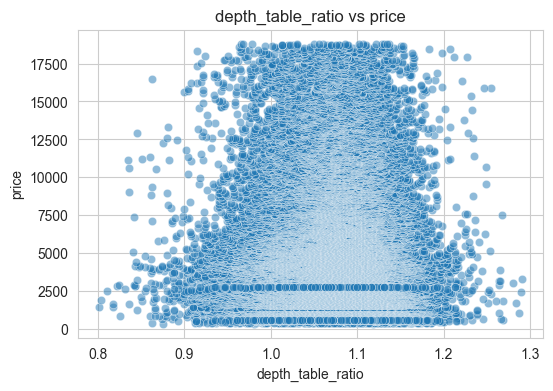

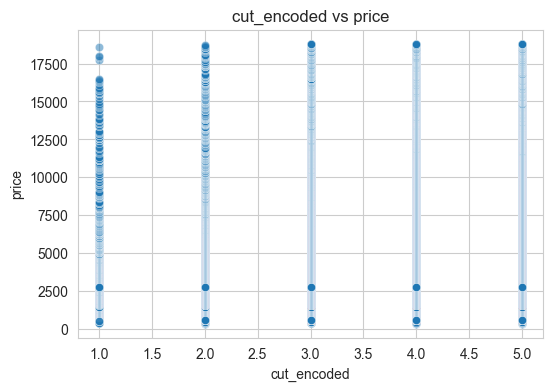

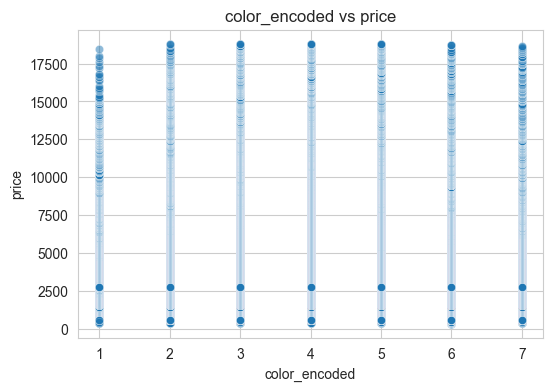

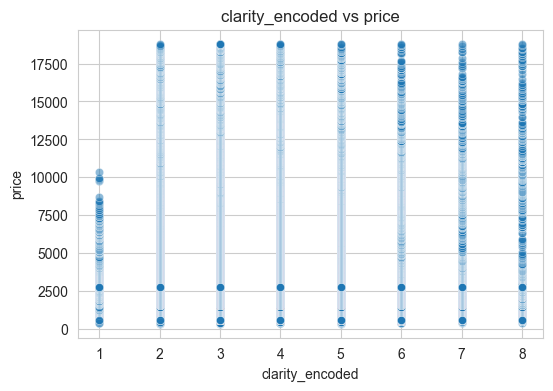

In [14]:
# Scatterplots with price
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=col, y=target_column, data=df, alpha=0.5)
    plt.title(f"{col} vs {target_column}")
    plt.show()


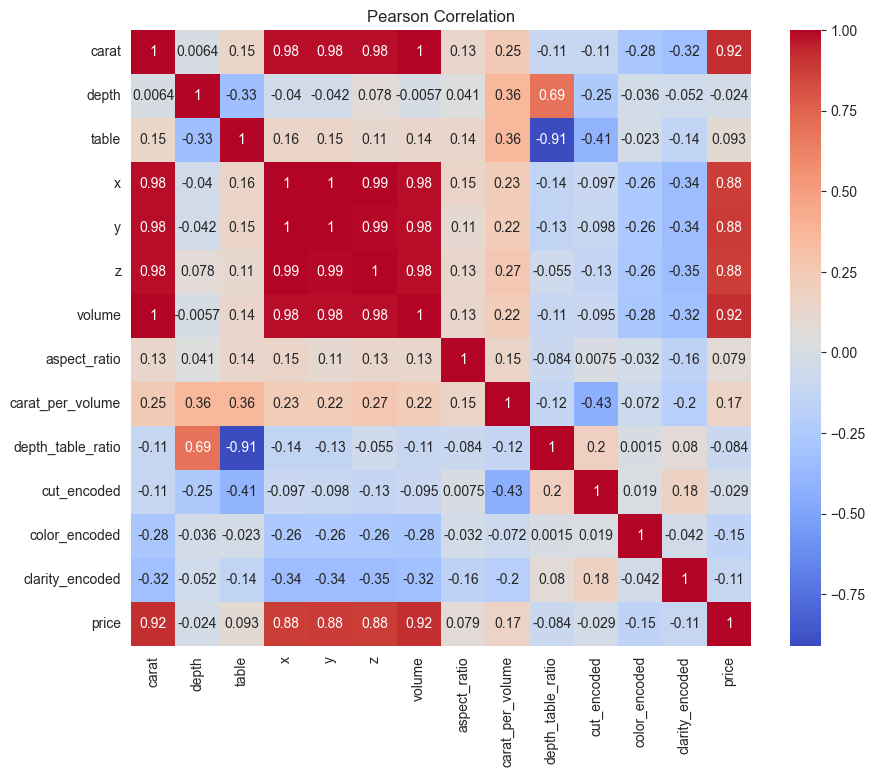

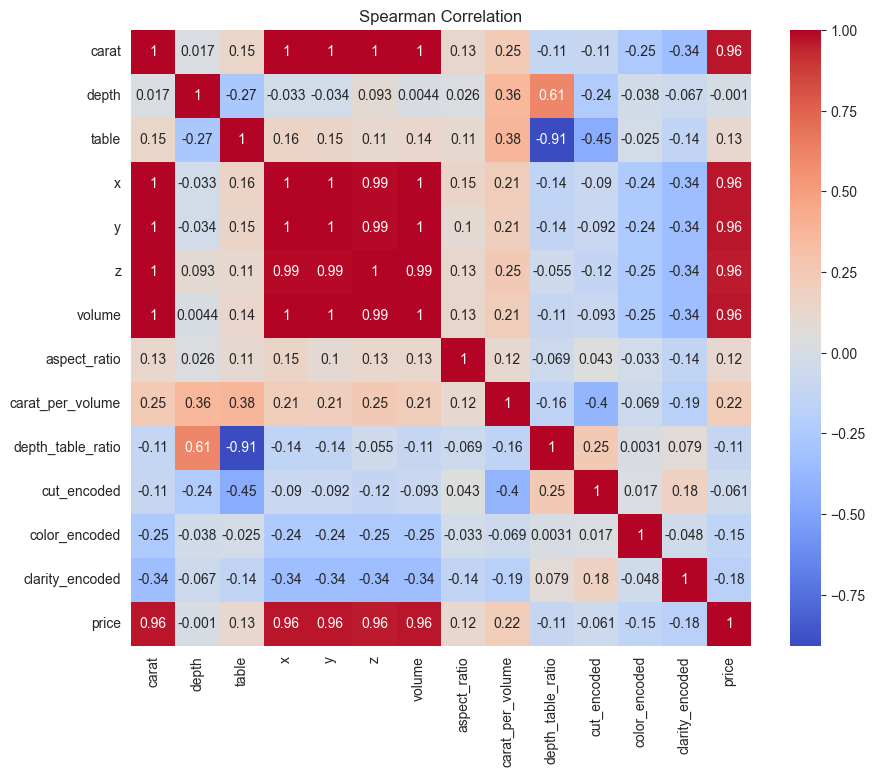

In [15]:
# Correlation heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[numerical_columns + [target_column]].corr(), annot=True, cmap="coolwarm"
)
plt.title("Pearson Correlation")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[numerical_columns + [target_column]].corr(method="spearman"),
    annot=True,
    cmap="coolwarm",
)
plt.title("Spearman Correlation")
plt.show()


 ## 5b. Categorical Features

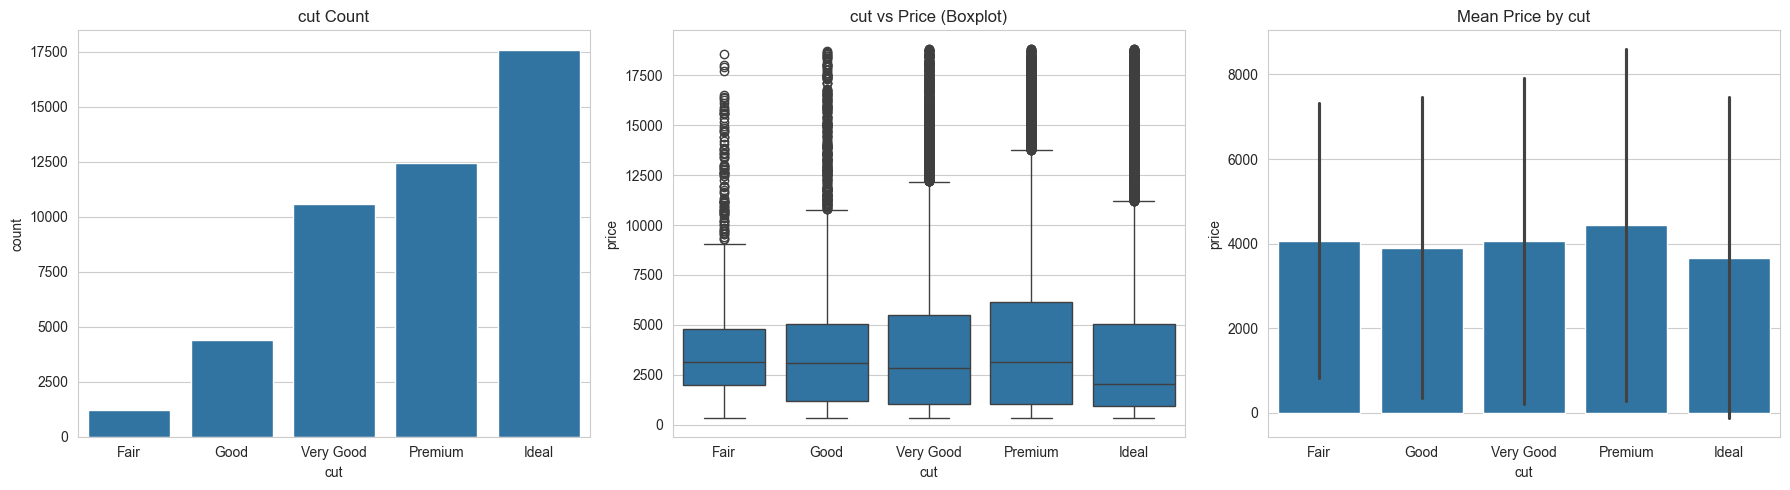

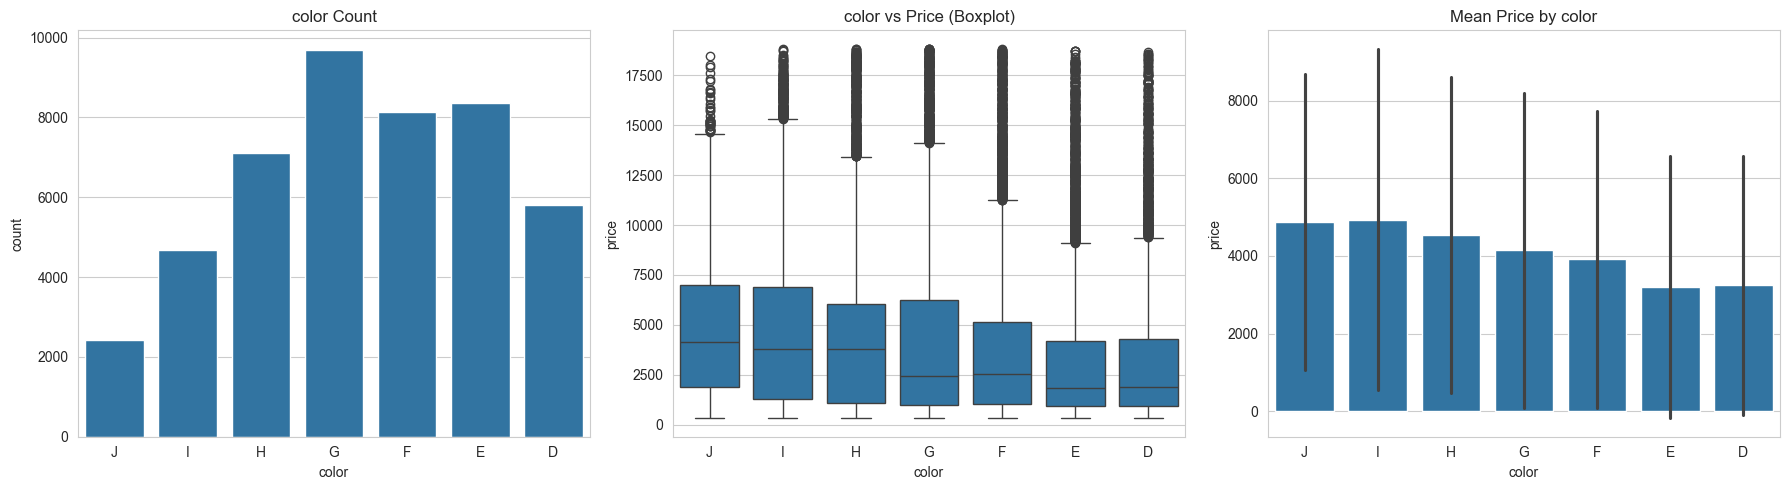

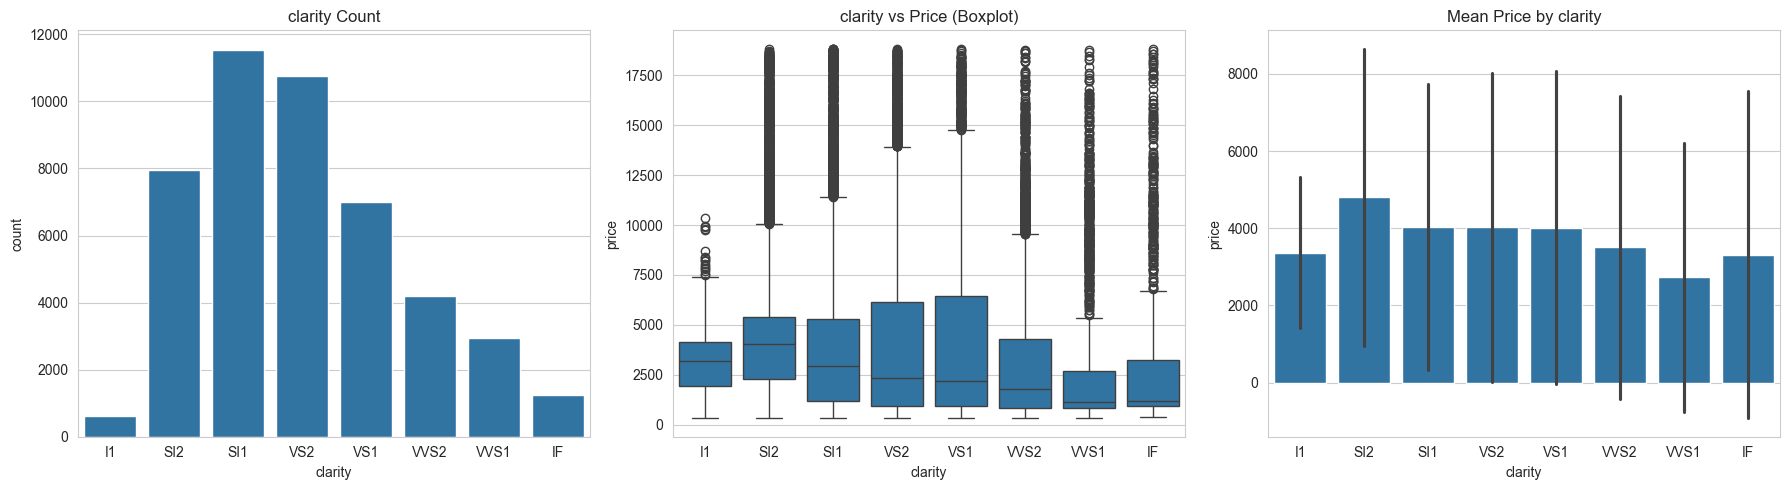

In [16]:
for col in categorical_columns:
    order = sorted(category_orders[col], key=category_orders[col].get)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.countplot(x=col, data=df, order=order, ax=axes[0])
    axes[0].set_title(f"{col} Count")

    sns.boxplot(x=col, y=target_column, data=df, order=order, ax=axes[1])
    axes[1].set_title(f"{col} vs Price (Boxplot)")

    sns.barplot(
        x=col,
        y=target_column,
        data=df,
        order=order,
        estimator="mean",
        errorbar="sd",
        ax=axes[2],
    )
    axes[2].set_title(f"Mean Price by {col}")

    plt.tight_layout()
    plt.show()


 # 6️⃣ Feature Selection

In [17]:
# Drop high multicollinearity columns
high_multicollinearity_columns_to_drop = ["x", "y", "z", "volume"]
numerical_columns = [
    col
    for col in numerical_columns
    if col not in high_multicollinearity_columns_to_drop
]
df = df.drop(columns=high_multicollinearity_columns_to_drop)


 # 7️⃣ Train-Test Split

In [18]:
X = df[numerical_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


 # 8️⃣ Polynomial Regression & BIC Selection

In [19]:
# Polynomial degree 3 from BIC
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

print(
    f"Train R²: {r2_score(y_train, y_train_pred):.4f}, Test R²: {r2_score(y_test, y_test_pred):.4f}"
)
print(
    f"Train MSE: {mean_squared_error(y_train, y_train_pred):.2f}, Test MSE: {mean_squared_error(y_test, y_test_pred):.2f}"
)


Train R²: 0.9773, Test R²: 0.9760
Train MSE: 346910.54, Test MSE: 355486.64


 # 9️⃣ Visualizations of Polynomial Fit

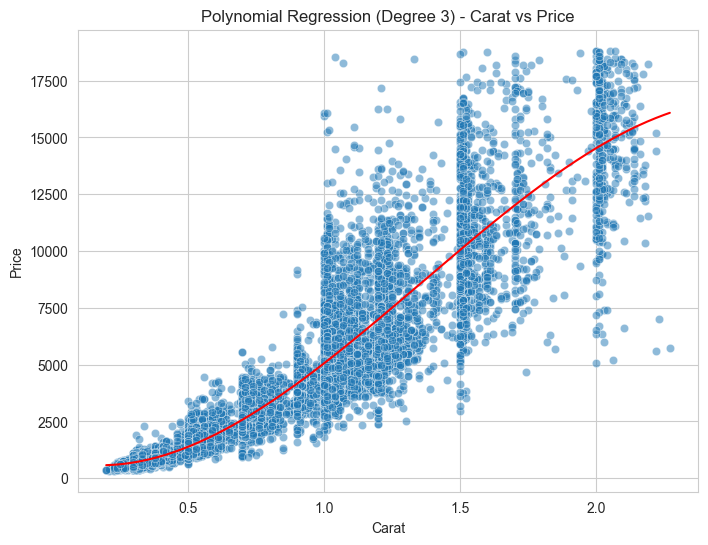

In [20]:
# Carat vs Price polynomial fit
carat_vals = np.linspace(df["carat"].min(), df["carat"].max(), 200).reshape(
    -1, 1
)
poly_single = PolynomialFeatures(degree=3, include_bias=False)
single_feature_model = LinearRegression().fit(
    poly_single.fit_transform(X_train[["carat"]]), y_train
)
carat_preds = single_feature_model.predict(poly_single.fit_transform(carat_vals))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test["carat"], y=y_test, alpha=0.5)
plt.plot(carat_vals, carat_preds, color="red")
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Polynomial Regression (Degree 3) - Carat vs Price")
plt.show()


 # 🔹 Optional: Regularized Regression with GridSearchCV

In [21]:
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Ridge Example
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring="r2")
ridge_cv.fit(X_train_poly, y_train)
y_test_ridge_pred = ridge_cv.predict(X_test_poly)

print(f"Ridge best alpha: {ridge_cv.best_params_['alpha']}")
print(f"Ridge Test R²: {r2_score(y_test, y_test_ridge_pred):.4f}")

# Similarly, Lasso and ElasticNet can be tried


Ridge best alpha: 0.01
Ridge Test R²: 0.9759
